In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from fbprophet import Prophet
import yfinance as yf
from datetime import date
import itertools
from fbprophet.diagnostics import performance_metrics
from fbprophet.diagnostics import cross_validation
from fbprophet.plot import plot_cross_validation_metric
import dill as pickle

# Data Preprocessing

In [2]:
# fetch the data
siemen = yf.Ticker("SIE.DE")
siemen

yfinance.Ticker object <SIE.DE>

In [3]:
#Get historical data
sie_data = siemen.history(start ="2015-01-01", end=date.today(), interval="1d")

sie_data.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2021-06-10,136.300003,136.580002,134.860001,135.100006,1029357,0.0,0
2021-06-11,135.300003,136.759995,134.500000,136.720001,1035025,0.0,0
2021-06-14,137.000000,138.240005,135.600006,135.740005,935042,0.0,0
2021-06-15,136.800003,138.839996,136.460007,138.600006,1300113,0.0,0
2021-06-16,139.220001,139.240005,136.539993,136.779999,1381080,0.0,0


### Data Visualization

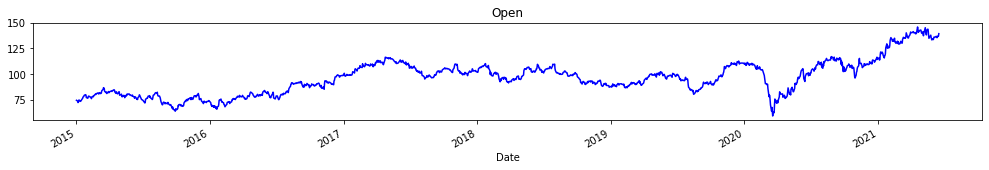

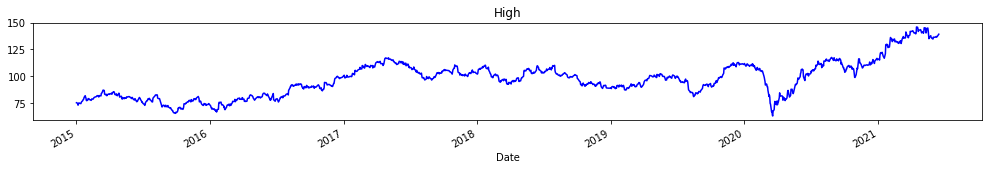

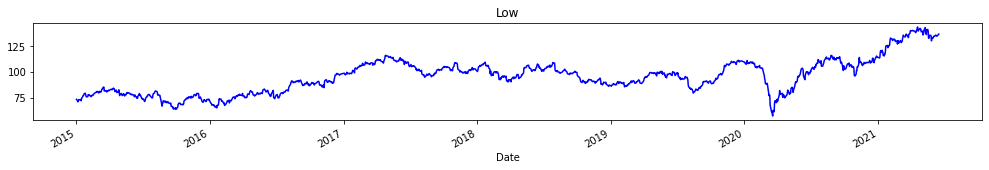

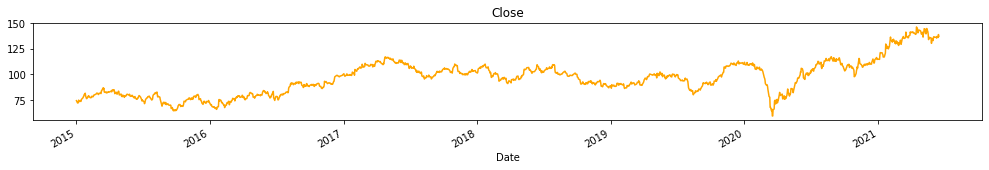

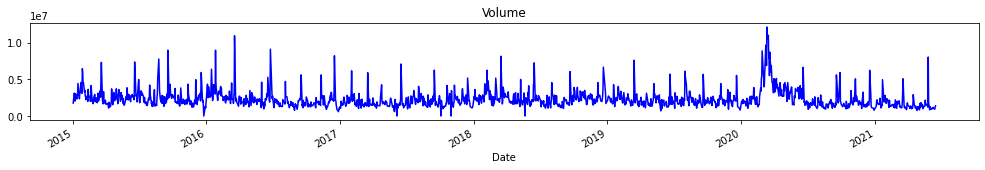

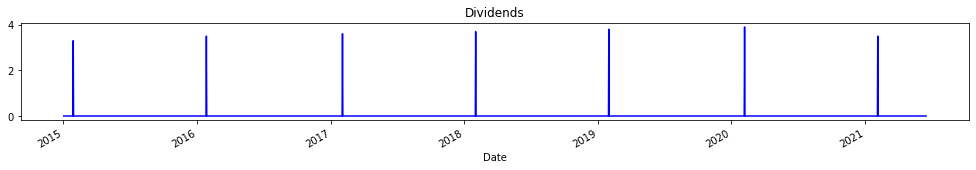

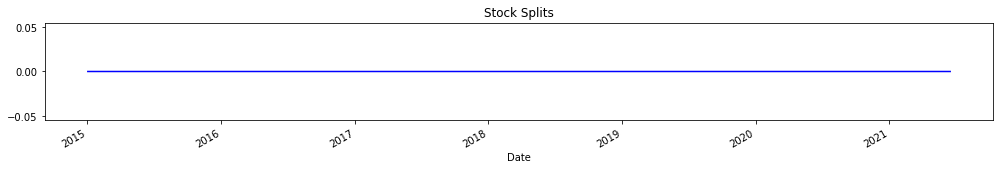

In [4]:
%matplotlib inline

for col in sie_data.columns:
    color="orange" if col == "Close" else "blue"
    sie_data[col].plot(figsize=(17, 2), color=color)
    plt.title(col)
    plt.show()

In [5]:
# Reset the index, change Date to column
sie_data = sie_data.reset_index()
sie_data.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2015-01-02,74.446556,75.230536,73.385406,74.248581,1758856,0.0,0
1,2015-01-05,73.828881,74.779159,71.983751,72.007507,3126357,0.0,0
2,2015-01-06,72.308426,73.076571,70.978033,71.944153,2718101,0.0,0
3,2015-01-07,72.379694,73.116162,71.809525,72.403450,2032739,0.0,0
4,2015-01-08,73.567554,74.834594,73.092415,74.771240,3039053,0.0,0


In [7]:
#check if date is in datetime format
sie_data.Date.dtype

dtype('<M8[ns]')

In [8]:
#save the dataframe to csv
sie_data.to_csv("siemens.csv")

### Changing the Column names
Facebook prophet takes only two features(columns). The column names must be ds: date, s:close. We are going to rename our columns.

In [9]:
#Extracting the date and close price columns
sie_df = sie_data[["Date", "Close"]]
sie_df.head()

,Date,Close
0,2015-01-02,74.248581
1,2015-01-05,72.007507
2,2015-01-06,71.944153
3,2015-01-07,72.403450
4,2015-01-08,74.771240


In [10]:
#rename the columns
sie_df = sie_df.rename(columns={'Date': 'ds', 'Close': 'y'})
sie_df.head()

,ds,y
0,2015-01-02,74.248581
1,2015-01-05,72.007507
2,2015-01-06,71.944153
3,2015-01-07,72.403450
4,2015-01-08,74.771240


### Splitting the Data

In [11]:
index = int(0.8 * sie_df.shape[0])
train_df = sie_df[:index]
test_df = sie_df[index:]

In [12]:
print(train_df.shape)
print(test_df.shape)

(1308, 2)
(328, 2)


### Hyperparameter Tuning

In [13]:
cutoffs = pd.to_datetime(["2016-01-09", "2016-07-09", "2017-01-09"])

In [14]:
# import itertools
# from fbprophet.diagnostics import performance_metrics
# from fbprophet.diagnostics import cross_validation
# from fbprophet.plot import plot_cross_validation_metric
# param_grid = {  
#     'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
#     'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
# }

# # Generate all combinations of parameters
# all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
# rmses = []  # Store the RMSEs for each params here

# # Use cross validation to evaluate all parameters
# for params in all_params:
#     m = Prophet(**params).fit(train_df)  # Fit model with given params
#     df_cv = cross_validation(m, initial='730 days', period = '31 days', horizon = '365 days')
#     cutoffs = df_cv.groupby('cutoff').mean().reset_index()['cutoff']
#     cutoff = df_cv['cutoff'].unique()[0]
#     df_cv = df_cv[df_cv['cutoff'].values == cutoff]

#     rmses.append(df_p['rmse'].values[0])

# # Find the best parameters
# tuning_results = pd.DataFrame(all_params)
# tuning_results['rmse'] = rmses
# print(tuning_results)

## Fitting the Model

In [15]:
model = Prophet(changepoint_prior_scale=0.15, daily_seasonality=True,yearly_seasonality=True, interval_width = 0.95)
model.add_seasonality('self_define_cycle',period=8,fourier_order=8,mode='additive')
model.fit(train_df)

## Make Future Prediction
👇Before predicting future values with Facebook's Prophet library, you first need to create a placeholder dataframe that will eventually hold the predictions. Once you create the dataframe, try to predict 2 years in the future.

You can create the predictions' dataframe using `make_future_dataframe()`

In [16]:
horizon = 36
future = model.make_future_dataframe(periods =horizon, freq="M")
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1339,2022-09-30,147.694028,-341.412886,644.399739
1340,2022-10-31,153.675820,-370.533258,672.645329
1341,2022-11-30,158.992983,-390.252858,707.792538
1342,2022-12-31,160.823824,-413.687566,738.008925
1343,2023-01-31,162.955832,-426.378864,765.605477


## Plotting the Forecast

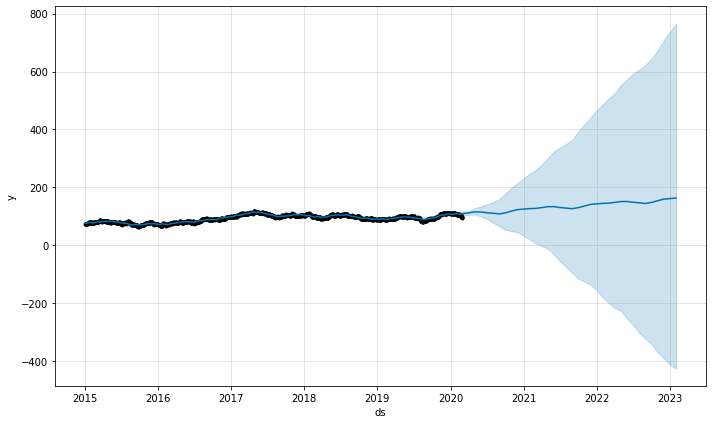

In [17]:
ax = model.plot(forecast);

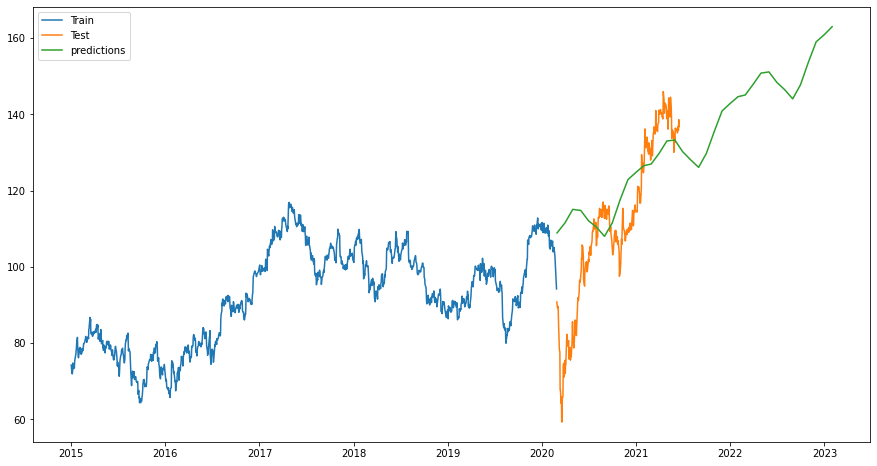

In [18]:
#Plotting the train, test and forecast for comparison
plt.figure(figsize=(15, 8))
plt.plot(train_df['ds'], train_df['y'], label="Train")
plt.plot(test_df['ds'], test_df['y'], label="Test")
plt.plot(forecast[-horizon:]['ds'], forecast[-horizon:]['yhat'], label="predictions")
plt.legend(loc="best")
plt.show()

The Train data is from 2015-the beginning of 2020, while the test data is from the beginning of 2020 to middle of 2021 and our forecasted data started predicting from 2020 to 2023

## Time Series' trend and seasonality

👇 Plot the trend and yearly seasonality of the time series. This can be done using the `plot_components()` function from Facebook's Prophet Library

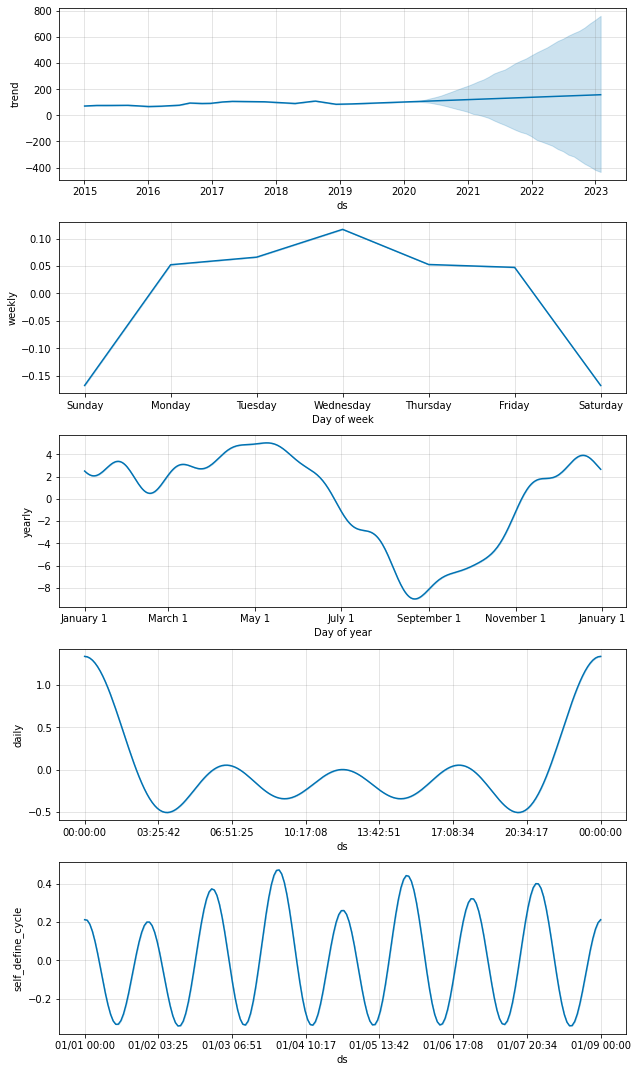

In [19]:
model.plot_components(forecast);

## Evaluating the model with cross-validation!
👇 Using cross_validation() and performance_metrics() from fbprophet.diagnostics, evaluate the performance of your model

More precisely, create a Time Series K-fold CV with

* train sets of size 5 years
* horizon val sizes of 1 years
* shifting each fold by 180 days


In [20]:
# Your code here
cv_results = cross_validation(model=model, initial=f'{365 * 3} days', horizon='365 days', period='180 days')

INFO:fbprophet:Making 3 forecasts with cutoffs between 2018-03-04 00:00:00 and 2019-02-27 00:00:00


  0%|          | 0/3 [00:00<?, ?it/s]

In [21]:
cv_results.tail()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
748,2020-02-21,89.274052,-89.872196,267.550419,102.629036,2019-02-27
749,2020-02-24,89.886313,-90.206092,270.139121,98.303307,2019-02-27
750,2020-02-25,90.100831,-92.150079,272.047327,96.705513,2019-02-27
751,2020-02-26,90.533736,-92.088470,272.773635,95.965073,2019-02-27
752,2020-02-27,90.590623,-94.103937,272.181276,94.211395,2019-02-27


In [22]:
#performance metrics
df_p = performance_metrics(cv_results)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,coverage
0,37 days,11.701009,3.420674,2.920589,0.030998,0.030148,0.873333
1,38 days,11.786430,3.433137,2.935869,0.031148,0.030148,0.873333
2,39 days,11.880421,3.446799,2.942579,0.031220,0.030148,0.873333
3,40 days,12.246175,3.499454,2.929548,0.031136,0.030148,0.880000
4,41 days,13.446972,3.667011,2.990067,0.031853,0.027919,0.875556


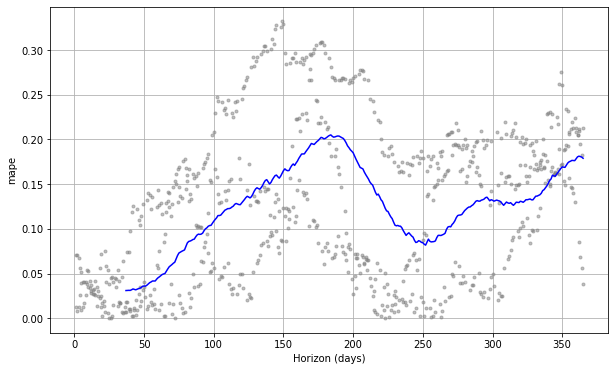

In [23]:
plot_cross_validation_metric(cv_results, metric='mape');

## Tuning our model

In [24]:
m = Prophet(
    growth="linear",
    seasonality_mode="additive",
    changepoint_prior_scale =30,
    seasonality_prior_scale=35,
    holidays_prior_scale = 20,
    daily_seasonality = False,
    weekly_seasonality = False,
    yearly_seasonality = False,).add_seasonality(
    name="monthly",
    period =30.5,
    fourier_order = 55).add_seasonality(
    name="daily",
    period =1,
    fourier_order = 15).add_seasonality(
    name="weekly",
    period = 7,
    fourier_order = 20).add_seasonality(
    name="yearly",
    period =365.25,
    fourier_order = 20).add_seasonality(
    name="quarterly",
    period =365.25/4,
    fourier_order = 15,
    prior_scale = 15)

In [25]:
m.fit(train_df)

In [28]:
# saving model to disk
pickle.dump(m,open("siemens.pkl","wb"))

In [29]:
import json
from fbprophet.serialize import model_to_json, model_from_json
with open('serialized_model.json', 'w') as siemens:
    json.dump(model_to_json(m), siemens)

In [30]:
horizon = 36
future = m.make_future_dataframe(periods =horizon, freq="M")
forecast2 = m.predict(future)
forecast2[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1339,2022-09-30,145.496522,-564.950697,847.983229
1340,2022-10-31,151.493271,-587.656682,888.535041
1341,2022-11-30,160.844561,-615.439379,930.296834
1342,2022-12-31,161.396760,-664.320015,971.372286
1343,2023-01-31,162.000008,-701.590637,997.229726


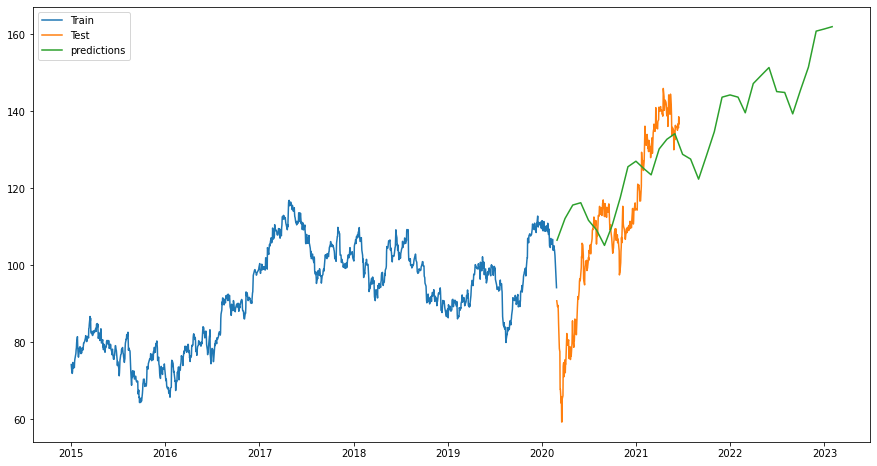

In [31]:
#Plotting the train, test and forecast for comparison
plt.figure(figsize=(15, 8))
plt.plot(train_df['ds'], train_df['y'], label="Train")
plt.plot(test_df['ds'], test_df['y'], label="Test")
plt.plot(forecast2[-horizon:]['ds'], forecast2[-horizon:]['yhat'], label="predictions")
plt.legend(loc="best")
plt.show()

In [32]:
# Your code here
cv_results = cross_validation(model=m, initial=f'{365 * 3} days', horizon='365 days', period='180 days')

INFO:fbprophet:Making 3 forecasts with cutoffs between 2018-03-04 00:00:00 and 2019-02-27 00:00:00


  0%|          | 0/3 [00:00<?, ?it/s]

In [33]:
#performance metrics
df_p = performance_metrics(cv_results)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,coverage
0,37 days,16.410323,4.050966,3.466853,0.036679,0.035930,0.433333
1,38 days,18.479330,4.298759,3.662799,0.038751,0.037224,0.420000
2,39 days,20.984127,4.580843,3.883628,0.041085,0.039111,0.400000
3,40 days,24.278197,4.927291,4.136063,0.043799,0.039811,0.373333
4,41 days,26.476344,5.145517,4.259509,0.045188,0.039871,0.368889


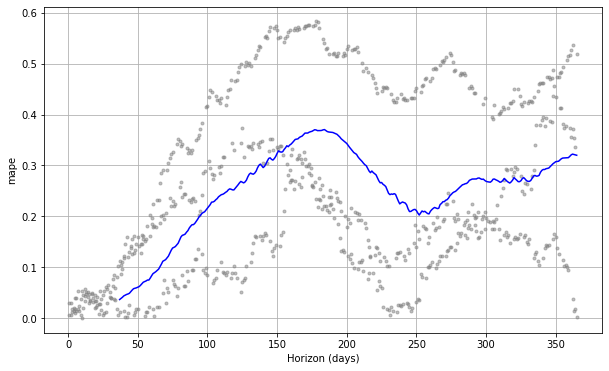

In [34]:
plot_cross_validation_metric(cv_results, metric='mape');